## Example: Exploring Marathon Finishing Times

Here we'll look at using Seaborn to help visualize and understand finishing results from a marathon.
I've scraped the data from sources on the Web, aggregated it and removed any identifying information, and put it on GitHub where it can be downloaded
(if you are interested in using Python for web scraping, I would recommend [*Web Scraping with Python*](http://shop.oreilly.com/product/0636920034391.do) by Ryan Mitchell).
We will start by downloading the data from
the Web, and loading it into Pandas:

In [1]:
# !curl -O https://raw.githubusercontent.com/jakevdp/marathon-data/master/marathon-data.csv

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
data = pd.read_csv('marathon-data.csv')
data.head()

,age,gender,split,final
0,33,M,01:05:38,02:08:51
1,32,M,01:06:26,02:09:28
2,31,M,01:06:49,02:10:42
3,38,M,01:06:16,02:13:45
4,31,M,01:06:32,02:13:59


By default, Pandas loaded the time columns as Python strings (type ``object``); we can see this by looking at the ``dtypes`` attribute of the DataFrame:

In [4]:
data.dtypes

age        int64
gender    object
split     object
final     object
dtype: object

Let's fix this by providing a converter for the times:

In [5]:
import datetime
def convert_time(s):
    h, m, s = map(int, s.split(':'))
    return datetime.timedelta(hours=h, minutes=m, seconds=s)

data = pd.read_csv('marathon-data.csv',
                   converters={'split':convert_time, 'final':convert_time})
data.head()

,age,gender,split,final
0,33,M,01:05:38,02:08:51
1,32,M,01:06:26,02:09:28
2,31,M,01:06:49,02:10:42
3,38,M,01:06:16,02:13:45
4,31,M,01:06:32,02:13:59


In [6]:
data.dtypes

age                 int64
gender             object
split     timedelta64[ns]
final     timedelta64[ns]
dtype: object

That looks much better. For the purpose of our Seaborn plotting utilities, let's next add columns that give the times in seconds:

In [7]:
data['split_sec'] = data['split'].astype(int) / 1E9
data['final_sec'] = data['final'].astype(int) / 1E9
data.head()

,age,gender,split,final,split_sec,final_sec
0,33,M,01:05:38,02:08:51,3938.0,7731.0
1,32,M,01:06:26,02:09:28,3986.0,7768.0
2,31,M,01:06:49,02:10:42,4009.0,7842.0
3,38,M,01:06:16,02:13:45,3976.0,8025.0
4,31,M,01:06:32,02:13:59,3992.0,8039.0


To get an idea of what the data looks like, we can plot a ``jointplot`` over the data:

/home/prathamesh/miniconda3/envs/ML/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


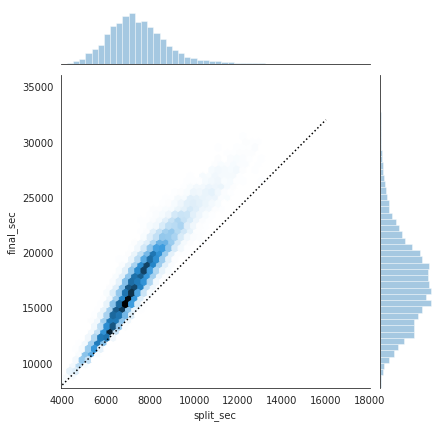

In [8]:
with sns.axes_style('white'):
    g = sns.jointplot("split_sec", "final_sec", data, kind='hex')
    g.ax_joint.plot(np.linspace(4000, 16000),
                    np.linspace(8000, 32000), ':k')

The dotted line shows where someone's time would lie if they ran the marathon at a perfectly steady pace. The fact that the distribution lies above this indicates (as you might expect) that most people slow down over the course of the marathon.
If you have run competitively, you'll know that those who do the opposite—run faster during the second half of the race—are said to have "negative-split" the race.

Let's create another column in the data, the split fraction, which measures the degree to which each runner negative-splits or positive-splits the race:

In [9]:
data['split_frac'] = 1 - 2 * data['split_sec'] / data['final_sec']
data.head()

,age,gender,split,final,split_sec,final_sec,split_frac
0,33,M,01:05:38,02:08:51,3938.0,7731.0,-0.018756
1,32,M,01:06:26,02:09:28,3986.0,7768.0,-0.026262
2,31,M,01:06:49,02:10:42,4009.0,7842.0,-0.022443
3,38,M,01:06:16,02:13:45,3976.0,8025.0,0.009097
4,31,M,01:06:32,02:13:59,3992.0,8039.0,0.006842


Where this split difference is less than zero, the person negative-split the race by that fraction.
Let's do a distribution plot of this split fraction:

/home/prathamesh/miniconda3/envs/ML/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


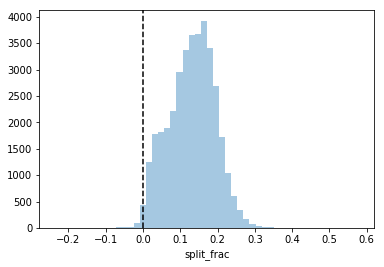

In [10]:
sns.distplot(data['split_frac'], kde=False);
plt.axvline(0, color="k", linestyle="--");

In [11]:
sum(data.split_frac < 0)

251

Out of nearly 40,000 participants, there were only 250 people who negative-split their marathon.

Let's see whether there is any correlation between this split fraction and other variables. We'll do this using a ``pairgrid``, which draws plots of all these correlations:

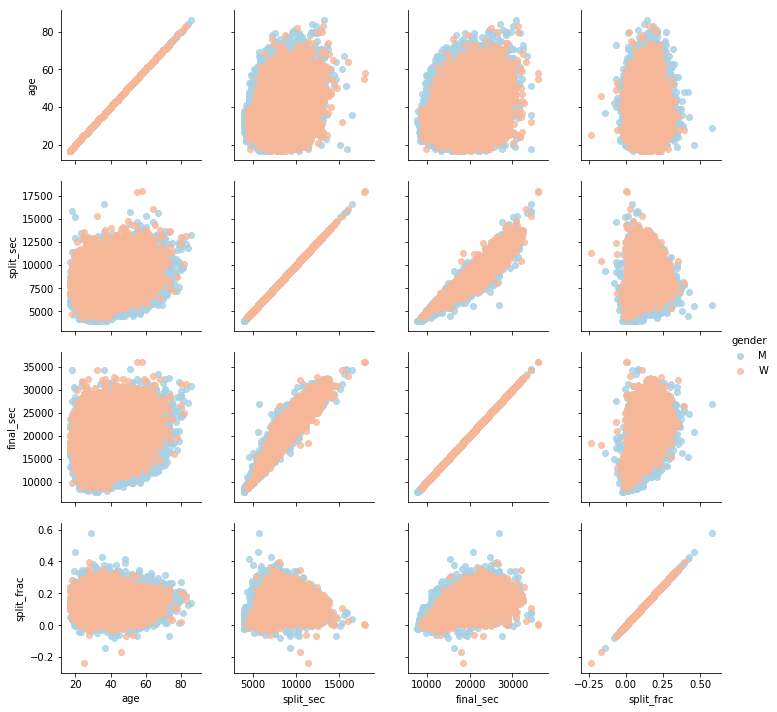

In [12]:
g = sns.PairGrid(data, vars=['age', 'split_sec', 'final_sec', 'split_frac'],
                 hue='gender', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

It looks like the split fraction does not correlate particularly with age, but does correlate with the final time: faster runners tend to have closer to even splits on their marathon time.
(We see here that Seaborn is no panacea for Matplotlib's ills when it comes to plot styles: in particular, the x-axis labels overlap. Because the output is a simple Matplotlib plot, however, the methods in [Customizing Ticks](04.10-Customizing-Ticks.ipynb) can be used to adjust such things if desired.)

The difference between men and women here is interesting. Let's look at the histogram of split fractions for these two groups:

/home/prathamesh/miniconda3/envs/ML/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


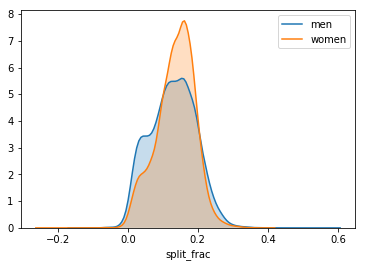

In [13]:
sns.kdeplot(data.split_frac[data.gender=='M'], label='men', shade=True)
sns.kdeplot(data.split_frac[data.gender=='W'], label='women', shade=True)
plt.xlabel('split_frac');

The interesting thing here is that there are many more men than women who are running close to an even split!
This almost looks like some kind of bimodal distribution among the men and women. Let's see if we can suss-out what's going on by looking at the distributions as a function of age.

A nice way to compare distributions is to use a *violin plot*

/home/prathamesh/miniconda3/envs/ML/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


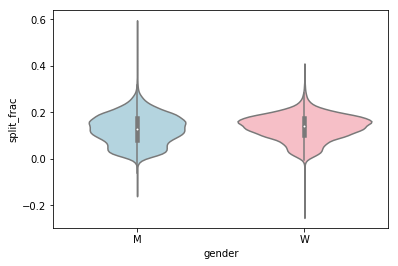

In [14]:
sns.violinplot("gender", "split_frac", data=data,
               palette=["lightblue", "lightpink"]);

This is yet another way to compare the distributions between men and women.

Let's look a little deeper, and compare these violin plots as a function of age. We'll start by creating a new column in the array that specifies the decade of age that each person is in:

In [15]:
data['age_dec'] = data.age.map(lambda age: 10 * (age // 10))
data.head()

,age,gender,split,final,split_sec,final_sec,split_frac,age_dec
0,33,M,01:05:38,02:08:51,3938.0,7731.0,-0.018756,30
1,32,M,01:06:26,02:09:28,3986.0,7768.0,-0.026262,30
2,31,M,01:06:49,02:10:42,4009.0,7842.0,-0.022443,30
3,38,M,01:06:16,02:13:45,3976.0,8025.0,0.009097,30
4,31,M,01:06:32,02:13:59,3992.0,8039.0,0.006842,30


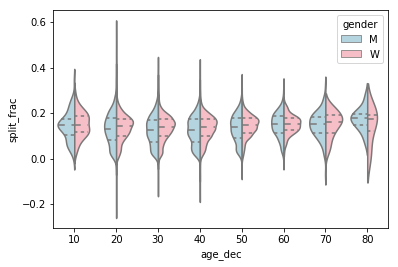

In [16]:
men = data.gender == 'M'
women = data.gender == 'W'

with sns.axes_style(style=None):
    sns.violinplot("age_dec", "split_frac", hue="gender", data=data,
                   split=True, inner="quartile",
                   palette=["lightblue", "lightpink"]);

Looking at this, we can see where the distributions of men and women differ: the split distributions of men in their 20s to 50s show a pronounced over-density toward lower splits when compared to women of the same age (or of any age, for that matter).

Also surprisingly, the 80-year-old women seem to outperform *everyone* in terms of their split time. This is probably due to the fact that we're estimating the distribution from small numbers, as there are only a handful of runners in that range:

In [17]:
(data.age > 80).sum()

7

Back to the men with negative splits: who are these runners? Does this split fraction correlate with finishing quickly? We can plot this very easily. We'll use ``regplot``, which will automatically fit a linear regression to the data:

/home/prathamesh/miniconda3/envs/ML/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


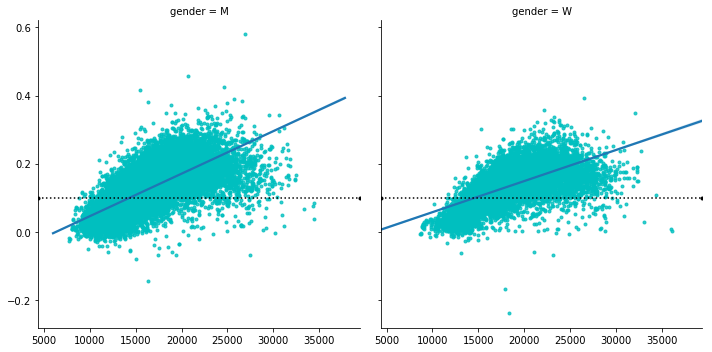

In [18]:
g = sns.lmplot('final_sec', 'split_frac', col='gender', data=data,
               markers=".", scatter_kws=dict(color='c'))
g.map(plt.axhline, y=0.1, color="k", ls=":");

Apparently the people with fast splits are the elite runners who are finishing within ~15,000 seconds, or about 4 hours. People slower than that are much less likely to have a fast second split.